In [1]:
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym


from graph_reinforcement_learning_using_blockchain_data import config
from graph_reinforcement_learning_using_blockchain_data.modeling import rl
from graph_reinforcement_learning_using_blockchain_data import plots

2025-03-21 10:29:02.124 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:11 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


In [2]:
df = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "features_edges_multiocc.csv")

In [3]:
agent = PPO.load(
    "../mlartifacts/129194754010327223/87b51321daa141a7abf7b5a551a3fec0/artifacts/ppo_soft_embeddings_v1.zip"
)

In [9]:
max_addresses = df.groupby("blockNumber")["from"].nunique().max()

unique_blocks = np.sort(df["blockNumber"].unique())
split_index = int(0.8 * len(unique_blocks))
train_blocks = unique_blocks[:split_index]
test_blocks = unique_blocks[split_index:]

df_train = df[df["blockNumber"].isin(train_blocks)]
df_test = df[df["blockNumber"].isin(test_blocks)]

print(
    f"Train blocks: {len(train_blocks)}, Test blocks: {len(test_blocks)}, Total blocks: {len(unique_blocks)}"
)
print(
    f"Range Train blocks: {train_blocks.min()} - {train_blocks.max()}, range Test blocks: {test_blocks.min()} - {test_blocks.max()}"
)

Train blocks: 70292, Test blocks: 17573, Total blocks: 87865
Range Train blocks: 16950601 - 17410727, range Test blocks: 17410733 - 17517773


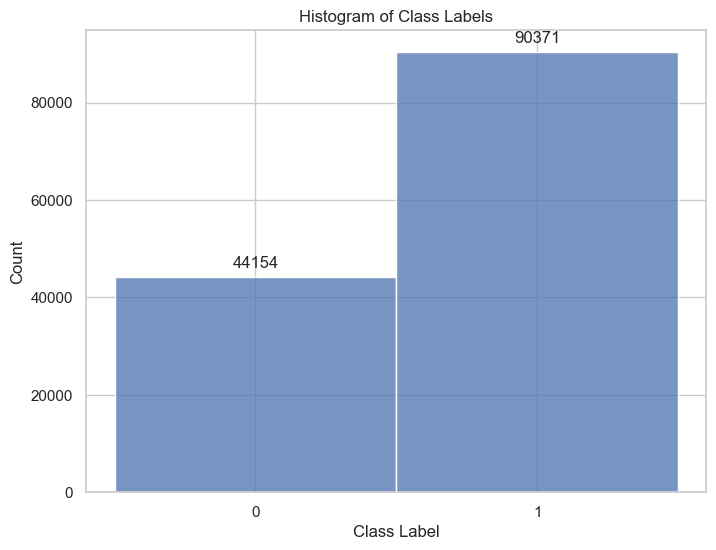

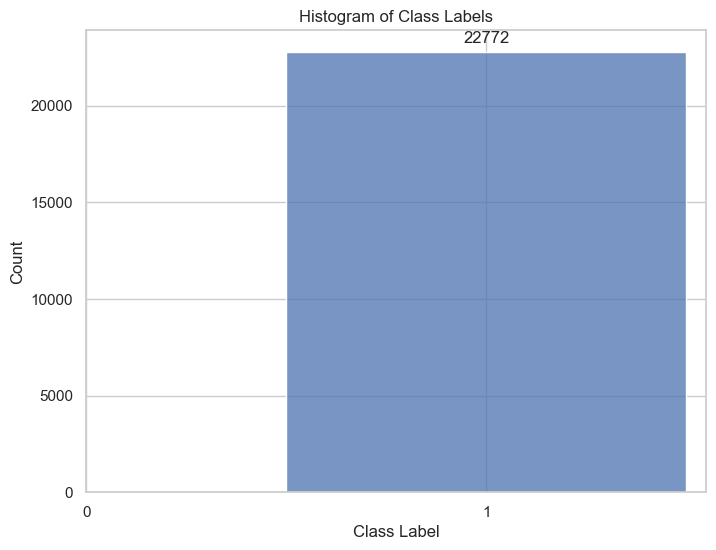

In [6]:
plots.plot_hist(df_train, "label")
plots.plot_hist(df_test, "label")

In [15]:
x = df[df["label"] == 0].sort_values("blockNumber", ascending=True)["blockNumber"].unique()

In [5]:
max_num_addresses = max_addresses
embedding_dim = 128
feature_cols = [
    "gasUsed",
    "cumulativeGasUsed",
    "effectiveGasPrice",
    "status",
    "fee",
    "num_logs",
    "dummy_0xd78ad95f",
    "dummy_0xe1fffcc4",
    "dummy_0x908fb5ee",
    "dummy_0xe9149e1b",
    "dummy_0x1c411e9a",
    "dummy_0x9d9af8e3",
    "dummy_0x19b47279",
    "dummy_0x8201aa3f",
    "dummy_0xc42079f9",
    "dummy_0xddf252ad",
    "dummy_0x17307eab",
    "dummy_0xddac4093",
    "dummy_0x8c5be1e5",
    "dummy_0x7fcf532c",
]
alpha = 0.3

train_env = rl.BlockchainEnv(df_train, max_num_addresses, embedding_dim, feature_cols, alpha)
test_env = rl.BlockchainEnv(df_test, max_num_addresses, embedding_dim, feature_cols, alpha)

# train_env = gym.wrappers.FlattenObservation(train_env)
# test_env = gym.wrappers.FlattenObservation(test_env)

train_env = Monitor(train_env)
test_env = Monitor(test_env)

check_env(train_env)
check_env(test_env)

vec_train_env = DummyVecEnv([lambda: train_env])
vec_test_env = DummyVecEnv([lambda: test_env])

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation states has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation states has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [7]:
rl.test(vec_test_env, agent)

OrderedDict({'mask': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]], dtype=int8), 'states': array([[[-1., -1., -1., ..., -1., -1., -1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)})


KeyboardInterrupt: 